Epoch 1/5 — G loss: 0.7198 | D loss: 0.6911
Epoch 2/5 — G loss: 0.6842 | D loss: 0.7591
Epoch 3/5 — G loss: 0.5585 | D loss: 0.7510
Epoch 4/5 — G loss: 0.6943 | D loss: 0.6895
Epoch 5/5 — G loss: 0.8354 | D loss: 0.5425


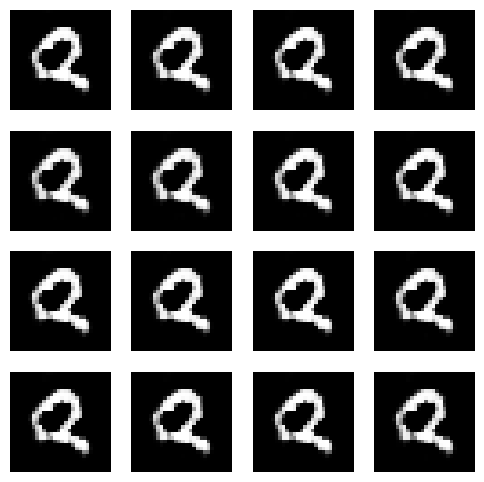

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt


(x_train, _), (_, _) = keras.datasets.mnist.load_data()
x_train = (x_train.astype("float32") - 127.5) / 127.5  # [-1,1]
x_train = np.expand_dims(x_train, axis=-1)  # (N,28,28,1)
BATCH_SIZE = 64
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(BATCH_SIZE)

LATENT_DIM = 128


def build_mapping_network(latent_dim=LATENT_DIM, dlatent_dim=128):
    inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(256, activation="relu")(inputs)
    x = layers.Dense(256, activation="relu")(x)
    out = layers.Dense(dlatent_dim)(x)
    return keras.Model(inputs, out, name="mapping")


class StyleConvBlock(layers.Layer):
    def __init__(self, filters, kernel_size=3, upsample=False):
        super().__init__()
        self.upsample = upsample
        self.conv = layers.Conv2D(filters, kernel_size, padding="same")
        self.act = layers.LeakyReLU(0.2)
        # We'll use a small Dense to generate per-channel gamma/beta from style
        self.to_gamma = layers.Dense(filters)
        self.to_beta = layers.Dense(filters)

    def call(self, x, style):  # x: (B,H,W,C)   style: (B, dlatent)
        if self.upsample:
            x = tf.image.resize(x, [tf.shape(x)[1]*2, tf.shape(x)[2]*2], method="nearest")
        x = self.conv(x)  # (B,H,W,C)

        # compute gamma & beta per-channel from style
        gamma = self.to_gamma(style)  # (B, C)
        beta = self.to_beta(style)    # (B, C)

        # reshape to (B,1,1,C) and apply affine
        gamma = tf.reshape(gamma, [-1, 1, 1, tf.shape(gamma)[-1]])
        beta  = tf.reshape(beta,  [-1, 1, 1, tf.shape(beta)[-1]])

        # adaptive instance normalization simplified: normalize per-channel then scale+shift
        mean, var = tf.nn.moments(x, axes=[1,2], keepdims=True)
        x = (x - mean) / tf.sqrt(var + 1e-8)
        x = x * (1.0 + gamma) + beta

        x = self.act(x)
        return x


class SimpleStyleGenerator(keras.Model):
    def __init__(self, latent_dim=LATENT_DIM, dlatent_dim=128):
        super().__init__(name="SimpleStyleG")
        self.latent_dim = latent_dim
        self.dlatent_dim = dlatent_dim

        # mapping network
        self.mapping = build_mapping_network(latent_dim, dlatent_dim)

        # learned constant (will be created in build())
        self.const = None

        # blocks: from small 7x7 -> upsample to 28x28 via two upsamples
        self.block1 = StyleConvBlock(128, upsample=False)  # 7x7
        self.block2 = StyleConvBlock(64, upsample=True)    # 14x14
        self.block3 = StyleConvBlock(32, upsample=True)    # 28x28
        self.to_rgb = layers.Conv2D(1, 1, activation="tanh", padding="same")

    def build(self, input_shape):
        # create learned 7x7 constant with channel=128
        # shape: (1,7,7,128) then tile to batch in call
        self.const = self.add_weight(shape=(1, 7, 7, 128),
                                     initializer=tf.random_normal_initializer(0, 1),
                                     trainable=True, name="const_input")
        super().build(input_shape)

    def call(self, z):
        # z: (B, latent_dim)
        style = self.mapping(z)  # (B, dlatent)
        batch = tf.shape(z)[0]
        x = tf.tile(self.const, [batch, 1, 1, 1])  # (B,7,7,128)

        x = self.block1(x, style)  # (B,7,7,128)
        x = self.block2(x, style)  # (B,14,14,64)
        x = self.block3(x, style)  # (B,28,28,32)
        out = self.to_rgb(x)       # (B,28,28,1) in [-1,1] due to tanh
        return out


def build_discriminator():
    inp = keras.Input(shape=(28,28,1))
    x = layers.Conv2D(64, 3, strides=2, padding="same")(inp)   # 14x14
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)    # 7x7
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1)(x)
    return keras.Model(inp, x, name="D")


G = SimpleStyleGenerator()
D = build_discriminator()

bce = keras.losses.BinaryCrossentropy(from_logits=True)
optG = keras.optimizers.Adam(2e-4, beta_1=0.5)
optD = keras.optimizers.Adam(2e-4, beta_1=0.5)

# Build models once (create weights)
_ = G(tf.random.normal([1, LATENT_DIM]))
_ = D(tf.random.normal([1,28,28,1]))


@tf.function
def train_step(real_images):
    batch = tf.shape(real_images)[0]
    z = tf.random.normal([batch, LATENT_DIM])

    with tf.GradientTape(persistent=True) as tape:
        fake = G(z, training=True)
        real_logits = D(real_images, training=True)
        fake_logits = D(fake, training=True)

        d_loss_real = bce(tf.ones_like(real_logits), real_logits)
        d_loss_fake = bce(tf.zeros_like(fake_logits), fake_logits)
        d_loss = 0.5 * (d_loss_real + d_loss_fake)

        g_loss = bce(tf.ones_like(fake_logits), fake_logits)

    gradsD = tape.gradient(d_loss, D.trainable_variables)
    optD.apply_gradients(zip(gradsD, D.trainable_variables))

    gradsG = tape.gradient(g_loss, G.trainable_variables)
    optG.apply_gradients(zip(gradsG, G.trainable_variables))

    return g_loss, d_loss


EPOCHS = 5
for ep in range(EPOCHS):
    for batch_images in dataset:
        g_l, d_l = train_step(batch_images)
    print(f"Epoch {ep+1}/{EPOCHS} — G loss: {g_l.numpy():.4f} | D loss: {d_l.numpy():.4f}")


def show_samples(n=16):
    z = tf.random.normal([n, LATENT_DIM])
    imgs = G(z, training=False).numpy()
    imgs = (imgs * 127.5 + 127.5).astype(np.uint8)
    rows = int(np.sqrt(n))
    fig, axes = plt.subplots(rows, rows, figsize=(6,6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(imgs[i, :, :, 0], cmap="gray")
        ax.axis("off")
    plt.show()

show_samples(16)
